# 1. Loading Data

- We have already saved data into two csv files, `Fundamental_features.csv` and `Tech_Features.csv`. <br>
- Here, we just load and record them as `data_f` and `data_t`.

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
data_f = pd.read_csv(r"Fundamental_features.csv",index_col=0)
#f for Fundamental
data_t = pd.read_csv(r"Tech_Features.csv",index_col = 0)
# t for Tech

# 2. Imputing missing values and Standardization

For both technical and fundamental features, there are some missing values.
1. For Techonical features, there are 23 stocks that contain missing values. Since, 23 is only a small amount of data out of 501, we decide to delete these 23 stocks.
2. However, for fundamental features, we drop the same 23 stocks and then impute mean to the rest of the null values.

### 2.1. Technical features

In [3]:
data_t.head()

,ticker,date,close_price,open_price,high,low,volume
0,A,2015-06-01,39.344406,41.430000,41.430000,40.849998,2440000.0
1,A,2015-06-02,39.527092,40.939999,41.139999,40.669998,2947500.0
2,A,2015-06-03,39.517475,41.310001,41.360001,40.939999,2722100.0
3,A,2015-06-04,38.979042,40.889999,41.080002,40.009998,4091900.0
4,A,2015-06-05,38.757900,40.540001,40.669998,40.200001,1760300.0


In [4]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497679 entries, 0 to 497678
Data columns (total 7 columns):
ticker         497679 non-null object
date           497679 non-null object
close_price    497057 non-null float64
open_price     497057 non-null float64
high           497057 non-null float64
low            497057 non-null float64
volume         497057 non-null float64
dtypes: float64(5), object(2)
memory usage: 30.4+ MB


In [5]:
data_t_train = data_t.copy()

Drop the missing values, record new `DataFrame` as data_t_train

In [6]:
#drop duplicated ZTS
row = data_t_train.shape[0]
data_t_train = data_t_train.drop([i for i in range(row-1,row-2017,-1)],axis = 0)

#find ticker short of data
ticker_delete = []
tickers = set(data_t_train["ticker"])
rst = data_t_train.groupby('ticker')['date'].count()
for ticker in tickers:
    if rst[ticker] != 1008:
        ticker_delete.append(ticker)

print("Stock with Missing data:")
print(ticker_delete)
for ticker in ticker_delete:
    data_t_train =data_t_train.drop(data_t[data_t["ticker"]== ticker ].index, axis = 0)

Stock with Missing data:
['ZBH', 'PNW', 'HIG', 'KHC', 'EVRG', 'DOW', 'JEF', 'VMC', 'CF', 'LIN', 'CTVA', 'COTY', 'BBT', 'FTV', 'LW', 'PPG', 'EW', 'WRK', 'HPE', 'OKE', 'UA', 'PYPL', 'DGX']


In [7]:
data_t_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483840 entries, 0 to 495662
Data columns (total 7 columns):
ticker         483840 non-null object
date           483840 non-null object
close_price    483840 non-null float64
open_price     483840 non-null float64
high           483840 non-null float64
low            483840 non-null float64
volume         483840 non-null float64
dtypes: float64(5), object(2)
memory usage: 29.5+ MB


### 2.2 Fandamental features

**2.2.1 Check null value in fundamental features**

In [8]:
data_f.head()
data_f = data_f.drop([501,502],axis = 0)

In [9]:
data_f = data_f.drop(["annualHoldingsTurnover","beta3Year","morningStarRiskRating","revenueQuarterlyGrowth","fundInceptionDate","annualReportExpenseRatio",
            "totalAssets","fundFamily","lastDividendValue","yield","threeYearAverageReturn","legalType","morningStarOverallRating",
             "priceToSalesTrailing12Months","ytdReturn","lastCapGain","category","fiveYearAverageReturn","sharesShortPreviousMonthDate",
            "priceHint","lastSplitDate","lastSplitFactor","maxAge","dateShortInterest"],axis=1)

In [10]:
data_f.describe()

,enterpriseToRevenue,profitMargins,enterpriseToEbitda,forwardEps,sharesOutstanding,bookValue,sharesShort,sharesPercentSharesOut,lastFiscalYearEnd,heldPercentInstitutions,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
count,498.000000,500.000000,466.000000,498.000000,5.000000e+02,498.000000,4.990000e+02,499.000000,5.000000e+02,499.000000,...,446.000000,497.000000,498.000000,490.000000,4.990000e+02,473.000000,5.010000e+02,473.000000,4.930000e+02,4.930000e+02
mean,4.331627,0.141542,15.877045,7.039157,5.844036e+08,30.761536,1.192832e+07,0.030645,1.544721e+09,0.824247,...,0.185233,4.848793,19.148590,0.038687,1.192863e+07,5.611658,5.133851e+10,47.014350,2.385243e+09,3.078259e+09
std,3.931133,0.137949,12.537420,8.116973,1.012855e+09,33.618928,1.513935e+07,0.027853,5.076509e+06,0.206018,...,1.128765,46.410489,14.274133,0.043193,1.582388e+07,6.784894,1.017999e+11,234.957879,5.113747e+09,5.616583e+09
min,-6.688000,-0.834840,1.865000,-2.690000,2.452870e+07,-64.585000,6.885750e+05,0.001400,1.525046e+09,0.000000,...,-0.955000,-223.000000,-12.315986,0.004700,6.957810e+05,0.010000,4.617153e+09,2.987453,-2.235500e+10,-2.135400e+08
25%,1.703250,0.066000,9.496250,3.085000,1.554410e+08,12.052500,3.697812e+06,0.013500,1.546214e+09,0.769790,...,-0.162000,1.120000,10.788344,0.014825,3.729430e+06,2.473000,1.262393e+10,13.388415,4.681000e+08,7.057770e+08
50%,3.319500,0.120070,13.342500,5.175000,2.957270e+08,21.663500,6.804688e+06,0.020400,1.546214e+09,0.869260,...,0.044000,1.700000,15.509059,0.024350,6.937551e+06,4.085000,2.262765e+10,20.837616,1.036900e+09,1.427000e+09
75%,5.274500,0.209037,18.635250,8.305000,5.477232e+08,39.476250,1.386922e+07,0.037400,1.546214e+09,0.949265,...,0.252500,2.780000,22.070777,0.044875,1.398515e+07,6.477000,4.590843e+10,33.132076,2.400000e+09,3.122000e+09
max,21.689000,0.903610,194.515000,113.580000,9.508200e+09,264.071000,1.148520e+08,0.192700,1.556582e+09,1.175780,...,19.044000,745.300000,160.156250,0.463100,1.489338e+08,88.292005,1.020000e+12,4400.000000,5.953100e+10,7.089800e+10


In [11]:
for ticker in ticker_delete:
    data_f =data_f.drop(data_f[data_f["Ticker"]== ticker ].index, axis = 0)

In [12]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 0 to 500
Data columns (total 33 columns):
Ticker                     478 non-null object
enterpriseToRevenue        477 non-null float64
profitMargins              477 non-null float64
enterpriseToEbitda         446 non-null float64
52WeekChange               477 non-null object
forwardEps                 476 non-null float64
sharesOutstanding          477 non-null float64
bookValue                  477 non-null float64
sharesShort                477 non-null float64
sharesPercentSharesOut     477 non-null float64
lastFiscalYearEnd          477 non-null float64
heldPercentInstitutions    477 non-null float64
netIncomeToCommon          477 non-null float64
trailingEps                477 non-null float64
SandP52WeekChange          477 non-null float64
priceToBook                453 non-null float64
heldPercentInsiders        477 non-null float64
nextFiscalYearEnd          477 non-null float64
mostRecentQuarter          477 no

In [13]:
data_f.describe()

,enterpriseToRevenue,profitMargins,enterpriseToEbitda,forwardEps,sharesOutstanding,bookValue,sharesShort,sharesPercentSharesOut,lastFiscalYearEnd,heldPercentInstitutions,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
count,477.000000,477.000000,446.000000,476.000000,4.770000e+02,477.000000,4.770000e+02,477.000000,4.770000e+02,477.000000,...,429.000000,476.000000,476.000000,472.000000,4.770000e+02,455.000000,4.780000e+02,455.000000,4.700000e+02,4.700000e+02
mean,4.357312,0.144137,15.802110,7.166912,5.899043e+08,30.778275,1.184102e+07,0.030699,1.544755e+09,0.826960,...,0.178916,4.988739,19.190966,0.038471,1.173953e+07,5.681592,5.240442e+10,44.331483,2.464372e+09,3.154313e+09
std,3.985226,0.136678,12.620803,8.267912,1.033596e+09,34.069119,1.478229e+07,0.027873,5.073810e+06,0.204468,...,1.129723,47.418923,14.480450,0.042099,1.480342e+07,6.889801,1.038863e+11,227.823176,5.192336e+09,5.732592e+09
min,-6.688000,-0.834840,1.865000,-2.690000,2.452870e+07,-64.585000,6.885750e+05,0.001400,1.525046e+09,0.000000,...,-0.955000,-223.000000,-12.315986,0.004700,6.957810e+05,0.010000,4.617153e+09,2.987453,-2.235500e+10,-2.135400e+08
25%,1.698000,0.066710,9.463000,3.095000,1.545200e+08,11.822000,3.674655e+06,0.013500,1.546214e+09,0.770360,...,-0.164000,1.120000,10.827396,0.014975,3.637147e+06,2.475500,1.263980e+10,13.399577,4.699985e+08,7.060078e+08
50%,3.343000,0.122020,13.315000,5.215000,2.966500e+08,21.627000,6.804688e+06,0.020300,1.546214e+09,0.875330,...,0.042000,1.690000,15.469780,0.024050,6.937551e+06,4.089000,2.275943e+10,20.829115,1.042950e+09,1.436668e+09
75%,5.297000,0.211000,18.462000,8.537500,5.430650e+08,39.355000,1.418658e+07,0.037600,1.546214e+09,0.951420,...,0.240000,2.765000,22.104058,0.045350,1.401929e+07,6.556000,4.704616e+10,33.073940,2.445264e+09,3.154000e+09
max,21.689000,0.903610,194.515000,113.580000,9.508200e+09,264.071000,1.148520e+08,0.192700,1.556582e+09,1.175780,...,19.044000,745.300000,160.156250,0.463100,1.266514e+08,88.292005,1.020000e+12,4400.000000,5.953100e+10,7.089800e+10


In [14]:
data_f.shape

(478, 33)

In [15]:
data_f.head()

,Ticker,enterpriseToRevenue,profitMargins,enterpriseToEbitda,52WeekChange,forwardEps,sharesOutstanding,bookValue,sharesShort,sharesPercentSharesOut,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
0,A,4.306,0.22255,17.757,0.051262617,3.40,3.159930e+08,16.153,4636334.0,0.0146,...,-0.112,2.30,20.673529,0.0146,3687978.0,3.443000,2.221115e+10,20.415335,3.160000e+08,9.740000e+08
1,AAL,0.958,0.03215,7.364,-0.2998188,5.76,4.448350e+08,-1.432,20867364.0,0.0469,...,0.164,0.41,5.340278,0.0561,23003563.0,3.118000,1.368313e+10,9.865298,1.412000e+09,3.757000e+09
2,AAP,1.428,0.04448,14.394,0.17042124,9.49,7.132690e+07,49.732,2867611.0,0.0400,...,0.042,1.09,16.177029,0.0471,2882176.0,5.856000,1.095011e+10,26.215847,4.238470e+08,7.121420e+08
3,AAPL,3.511,0.22117,11.732,-0.005647659,12.78,4.601080e+09,22.977,49550348.0,0.0108,...,-0.164,1.37,15.068858,0.0105,61003851.0,11.887001,8.860000e+11,16.200891,5.953100e+10,7.089800e+10
4,ABBV,4.507,0.16418,10.552,-0.22391498,9.42,1.478330e+09,-5.294,21309313.0,0.0144,...,-0.117,1.16,8.168790,0.0163,27575807.0,3.511000,1.140000e+11,21.916832,5.687000e+09,1.191100e+10


**2.2.2 Using Pipeline to impute missing data and standardize data**

First, copy data into data_f_train and reset the index

In [16]:
#copy into data_f
data_f_train = data_f.copy()

In [17]:
#reset the index
data_f_train.index = data_f["Ticker"]
data_f_train = data_f_train.drop(["Ticker"],axis = 1)

In [18]:
data_f_train=data_f_train.replace([np.inf, -np.inf,"infinity","Infinity"], np.nan)

**Building pipeline to transform data**

In [19]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):                            
        return X[self.attribute_names].values

features = data_f_train.columns

Preprocess_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector( features )), #set the parameter for DataDrameSelector
        ("imputer", SimpleImputer(strategy="mean")), 
        ("StandardScaler", StandardScaler(copy=True, with_mean=True, with_std=True))
               
    ])

In [20]:
data_f_train_pre = Preprocess_pipeline.fit_transform(data_f_train)

In [21]:
data_f_train_preprocessed = pd.DataFrame(data_f_train_pre)
data_f_train_preprocessed.index = data_f_train.index
data_f_train_preprocessed.columns = data_f_train.columns

In [22]:
data_f_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 478 entries, A to ZTS
Data columns (total 32 columns):
enterpriseToRevenue        478 non-null float64
profitMargins              478 non-null float64
enterpriseToEbitda         478 non-null float64
52WeekChange               478 non-null float64
forwardEps                 478 non-null float64
sharesOutstanding          478 non-null float64
bookValue                  478 non-null float64
sharesShort                478 non-null float64
sharesPercentSharesOut     478 non-null float64
lastFiscalYearEnd          478 non-null float64
heldPercentInstitutions    478 non-null float64
netIncomeToCommon          478 non-null float64
trailingEps                478 non-null float64
SandP52WeekChange          478 non-null float64
priceToBook                478 non-null float64
heldPercentInsiders        478 non-null float64
nextFiscalYearEnd          478 non-null float64
mostRecentQuarter          478 non-null float64
shortRatio                 478 non-n

In [23]:
data_f_train_preprocessed.describe()

,enterpriseToRevenue,profitMargins,enterpriseToEbitda,52WeekChange,forwardEps,sharesOutstanding,bookValue,sharesShort,sharesPercentSharesOut,lastFiscalYearEnd,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
count,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,...,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02
mean,6.642757e-17,1.402876e-16,1.261195e-16,-4.180756e-18,9.441541e-17,-3.602999e-17,6.410493e-17,-1.544557e-17,-1.602623e-17,1.495921e-14,...,1.277453e-18,2.101991e-17,8.849267e-17,1.440038e-16,-2.671039e-17,-3.123954e-17,-3.427258e-17,-1.660689e-17,-6.451139e-17,-8.129248e-19
std,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,...,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00
min,-2.777382e+00,-7.177671e+00,-1.144510e+00,-2.432609e+00,-1.195948e+00,-5.481467e-01,-2.804986e+00,-7.560297e-01,-1.053333e+00,-3.892534e+00,...,-1.060721e+00,-4.823129e+00,-2.182687e+00,-8.081173e-01,-7.475922e-01,-8.446646e-01,-4.604778e-01,-1.862091e-01,-4.825647e+00,-5.931023e-01
25%,-6.685675e-01,-5.675123e-01,-5.060096e-01,-7.328497e-01,-4.934419e-01,-4.220847e-01,-5.572432e-01,-5.533013e-01,-6.183172e-01,2.882339e-01,...,-2.896769e-01,-8.173787e-02,-5.779925e-01,-5.616450e-01,-5.476200e-01,-4.648584e-01,-3.831716e-01,-1.375714e-01,-3.856756e-01,-4.295993e-01
50%,-2.536693e-01,-1.620449e-01,-1.598959e-01,2.787908e-03,-2.331872e-01,-2.836344e-01,-2.680992e-01,-3.412249e-01,-3.720478e-01,2.882339e-01,...,-9.580504e-02,-6.957367e-02,-2.550691e-01,-3.319233e-01,-3.243532e-01,-2.094079e-01,-2.856589e-01,-1.026684e-01,-2.728688e-01,-2.976594e-01
75%,2.353447e-01,4.867837e-01,1.605143e-01,7.270540e-01,1.647780e-01,-4.504041e-02,2.499127e-01,1.548853e-01,2.472210e-01,2.882339e-01,...,2.673880e-02,-4.672615e-02,1.995029e-01,1.514493e-01,1.536062e-01,1.008857e-01,-5.163213e-02,-3.124251e-02,-9.271177e-17,0.000000e+00
max,4.358112e+00,5.568315e+00,1.467584e+01,4.168702e+00,1.291119e+01,8.646525e+00,6.862001e+00,6.983163e+00,5.824235e+00,2.335957e+00,...,1.764733e+01,1.566137e+01,9.765562e+00,1.016109e+01,7.778812e+00,1.230309e+01,9.323745e+00,1.961747e+01,1.109550e+01,1.193013e+01


In [24]:
#data_f_train_preprocessed.to_csv("Fundamental Preprocessed.csv")

**After the transformation above, we can see from the tables above that there is no null value and data is standardized (mean =0, std = 1)**

# 3. PCA

**However, there is one more step needed to be done bofore feeding data into clustering model:** <br>
There are strong correlations between the features, `Pricipal Components Anlysis (PCA)` can be used here to reduce dimensions and reduce correlations.

In [25]:
import seaborn as sns
sns.heatmap(data_f_train_preprocessed.corr())

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pylab as plt

In [27]:
pca_f = PCA(random_state=100)
_ = pca_f.fit(data_f_train_preprocessed)

In [28]:
acc_va_ratio = np.cumsum(pca_f.explained_variance_ratio_)

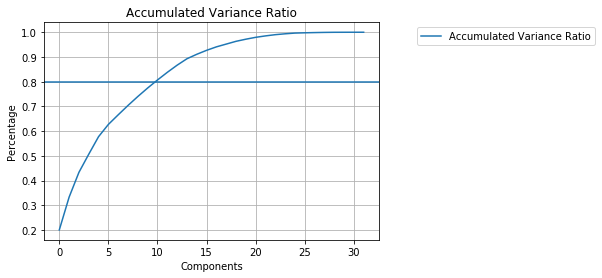

In [29]:
PCA_var_ratio=plt.figure()
plt.plot(acc_va_ratio)
plt.legend(["Accumulated Variance Ratio"],bbox_to_anchor=(1.1,1))
plt.grid()
plt.title("Accumulated Variance Ratio")
plt.xlabel('Components')
plt.ylabel('Percentage')
plt.axhline(y=0.8)
_ = plt.show()

If we set the threshold as 0.8, we can use 10 components to explain over 80% of the information.

In [30]:
X_f = pca_f.transform(data_f_train_preprocessed)

In [31]:
X_f = pd.DataFrame(X_f)
X_f.columns = [ "{}th component".format(i+1) for i in range(32)]
X_f.index = data_f_train.index

In [32]:
X_f.head()

,1th component,2th component,3th component,4th component,5th component,6th component,7th component,8th component,9th component,10th component,...,23th component,24th component,25th component,26th component,27th component,28th component,29th component,30th component,31th component,32th component
Ticker,,,,,,,,,,,,,,,,,,,,,
A,-0.745216,0.484528,0.742259,-1.345662,0.230530,-0.328233,0.107341,0.265886,1.005530,0.147379,...,-0.023408,-0.032055,0.027075,0.008740,-0.017456,-0.057234,0.005341,-0.001858,-0.003073,9.020109e-18
AAL,-0.023853,-1.758739,-2.579717,-1.828171,0.527858,3.653393,1.007211,-0.341563,0.918616,-0.198480,...,0.086791,-0.078682,-0.127927,-0.038610,0.073628,0.176865,0.099620,-0.040213,-0.006450,-3.811186e-16
AAP,-1.357082,0.881199,-0.661093,-0.102887,-0.835051,-0.425870,-1.141202,0.088909,0.499338,0.032003,...,-0.053259,-0.295922,-0.014104,-0.082233,-0.043777,0.035889,0.001107,0.002098,-0.003173,2.064553e-16
AAPL,21.623059,-2.136273,0.129156,3.667367,0.386970,-1.448666,-0.977086,-6.149047,2.061922,2.539742,...,-1.275623,-0.468471,-0.023191,0.307708,-0.341712,0.328911,0.346427,0.054983,0.006613,3.865535e-16
ABBV,2.413543,-1.269851,-0.262222,-0.499713,-0.642992,-0.221283,0.287141,0.038495,-0.146998,0.354259,...,-0.225729,0.238294,-0.618719,0.066574,-0.010892,0.280627,0.068836,-0.025018,-0.000454,8.395774e-17


In [33]:
X_f = X_f.drop(["{}th component".format(i) for i in range(11,33)],axis = 1)

In [34]:
from sklearn.cluster import MeanShift
import sklearn.metrics 

In [35]:
MS_cluster = MeanShift(bandwidth=7)
predicted = MS_cluster.fit_predict(X_f)

In [36]:
sklearn.metrics.calinski_harabaz_score(X = X_f,labels = predicted )

24.706803447335755

In [37]:
def find_optimal_bandwidth(start,end,interval):
    num_of_cluster = []
    ch_score = []
    for i in np.arange(start,end,interval):
        MS_cluster = MeanShift(bandwidth=i)
        predicted = MS_cluster.fit_predict(X_f)
        num_of_cluster.append(len(set(predicted) ))
        ch_score.append(sklearn.metrics.calinski_harabaz_score(X = X_f,labels = predicted ))
        
    print(num_of_cluster)
    MS_cluster_bandwidth=plt.figure()
    plt.plot(np.arange(start,end,interval),num_of_cluster)
    plt.plot(np.arange(start,end,interval),ch_score)
    plt.legend(["Number of clusters","CH_score"],bbox_to_anchor=(1.1,1))
    plt.grid()
    plt.title("Number of clusters and CH_score with different bandwidth")
    plt.xlabel('Bandwidth')
    plt.ylabel('Number of Clusters')
    _ = plt.show()

[28, 28, 27, 26, 23, 23, 22, 22, 22, 21, 21, 20, 19, 18, 17, 17, 17, 15, 15, 14, 13, 13, 13, 13, 12, 12, 12, 11, 11, 10, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


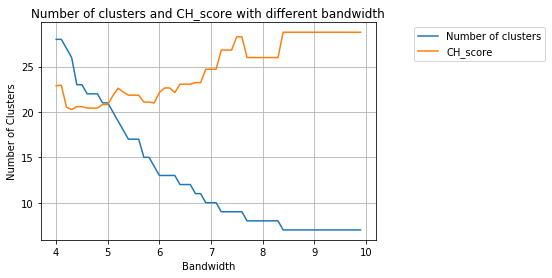

In [38]:
find_optimal_bandwidth(4,10,0.1) 